In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [6]:
device = torch.device('cuda:3')

In [3]:
import sys
sys.path.append('../../../')   # Include the path to torchuq in case it's not yet installed
from torchuq.dataset.ham import get_ham10000

In [4]:
train_dataset, val_dataset, test_dataset = get_ham10000('/atlas/u/shengjia/data/HAM10000/HAM10000', val_fraction=0.3, test_fraction=0.0, maybe_download=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Found 10015 images in the data directory
4501 images have duplicates, and 5514 images do not
Size of train/val/test splits = 7010/3005/0
------------------- Value counts on train ------------------- 
melanoma                          4940
Dermatofibroma                    4700
Melanocytic nevi                  4299
Benign keratosis-like lesions     4295
Vascular lesions                  4280
Basal cell carcinoma              4180
Actinic keratoses                 3675
Name: cell_type, dtype: int64
------------------- Value counts on val ------------------- 
Melanocytic nevi                  2406
Benign keratosis-like lesions      240
melanoma                           125
Basal cell carcinoma                96
Actinic keratoses                   82
Vascular lesions                    35
Dermatofibroma                      21
Name: cell_type, dtype: int64


In [7]:
# Get a pretrained network but replace the last layer
model_ft = models.densenet121(pretrained=True)
num_classes = 7
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)
model = model_ft.to(device)

In [8]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [11]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [12]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 950], [train loss 1.24324], [train acc 0.54187]
[epoch 1], [iter 200 / 950], [train loss 1.13621], [train acc 0.57953]
[epoch 1], [iter 300 / 950], [train loss 1.03737], [train acc 0.61656]
[epoch 1], [iter 400 / 950], [train loss 0.98170], [train acc 0.63555]
[epoch 1], [iter 500 / 950], [train loss 0.94355], [train acc 0.64956]
[epoch 1], [iter 600 / 950], [train loss 0.90657], [train acc 0.66349]
[epoch 1], [iter 700 / 950], [train loss 0.87884], [train acc 0.67188]
[epoch 1], [iter 800 / 950], [train loss 0.85058], [train acc 0.68125]
[epoch 1], [iter 900 / 950], [train loss 0.82704], [train acc 0.69035]
------------------------------------------------------------
[epoch 1], [val loss 0.72395], [val acc 0.77861]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.72395], [val acc 0.77861]
*****************************************************
[epoch 2], [iter 100

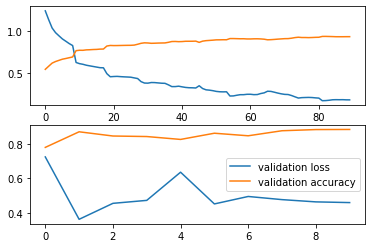

In [13]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

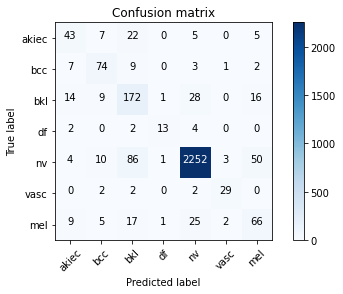

In [15]:
model.eval()
y_label = []
y_predict = []

prediction_list = []
label_list = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        prediction_list.append(outputs)
        label_list.append(labels)
predictions = (torch.cat(prediction_list) / 10.).softmax(dim=1).cpu()
labels = torch.cat(label_list).cpu()
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [26]:
import sys
sys.path.append('/atlas/u/shengjia/torchuq_release/')

import torchuq

import importlib
importlib.reload(torchuq.transform.basic)
importlib.reload(torchuq.transform.parametric)
from torchuq.transform.parametric import TemperatureScaling

calibrator = TemperatureScaling(verbose=True)
calibrator.train(predictions, labels)
predictions = calibrator(predictions).detach()

Iteration 0, lr=0.00100, NLL=0.975
Iteration 100, lr=0.00100, NLL=0.903
Iteration 200, lr=0.00100, NLL=0.819
Iteration 300, lr=0.00100, NLL=0.720
Iteration 400, lr=0.00100, NLL=0.609
Iteration 500, lr=0.00100, NLL=0.496
Iteration 600, lr=0.00100, NLL=0.404
Iteration 700, lr=0.00100, NLL=0.355
Iteration 800, lr=0.00100, NLL=0.341
Iteration 900, lr=0.00100, NLL=0.340
Iteration 1000, lr=0.00000, NLL=0.340


In [27]:
from torchuq.metric.categorical import compute_accuracy
compute_accuracy(predictions, labels)

tensor(0.8815)

In [28]:
torch.save({'predictions': predictions, 'labels': labels}, 'ham_densenet161/predictions.tar')